In [42]:
""" 
04 MARCH 2024 
Theo Gauvrit
Testing the higher baseline hypothesis to explain the no detection of tactile stimulus on KO mice.
"""

import numpy as np
import pandas as pd
import percephone.core.recording as pc
import os
import percephone.plts.behavior as pbh
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
import percephone.analysis.mlr_models as mlr_m
from multiprocessing import Pool, cpu_count
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline

In [43]:
directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
roi_info = pd.read_excel(directory + "/FmKO_ROIs&inhibitory.xlsx")
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]


The following cell is to process the opening of the recording faster by computing with all the processors available. It use the Python libray multiprocessing


In [44]:
def oprening_rec(fil,i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, fil, roi_info)
    return rec

workers = cpu_count()
pool = Pool(processes=workers)
async_results = [pool.apply_async(oprening_rec, args=(file,i)) for i,file in enumerate(files_)]
recs = [ar.get() for ar in async_results]

## H1 Group comparison between different baselines (before detected stimulus and baseline before undetected stimulus)


## H1 Comparison between baseline before detected stimulus and baseline before undetected stimulus in the same animal

Testing if the mean baseline before the stimulus detected and non detected is different in all the neurons of the two different group of mice.

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
MLR model already computed
Boxplot plotting.
 mean baseline
ShapiroResult(statistic=0.9620457291603088, pvalue=0.11500754207372665)
ShapiroResult(statistic=0.9496963024139404, pvalue=0.035902079194784164)
WilcoxonResult(

Text(0.5, 0.98, 'Mean baseline comparaison Det vs Undet for all neurons')

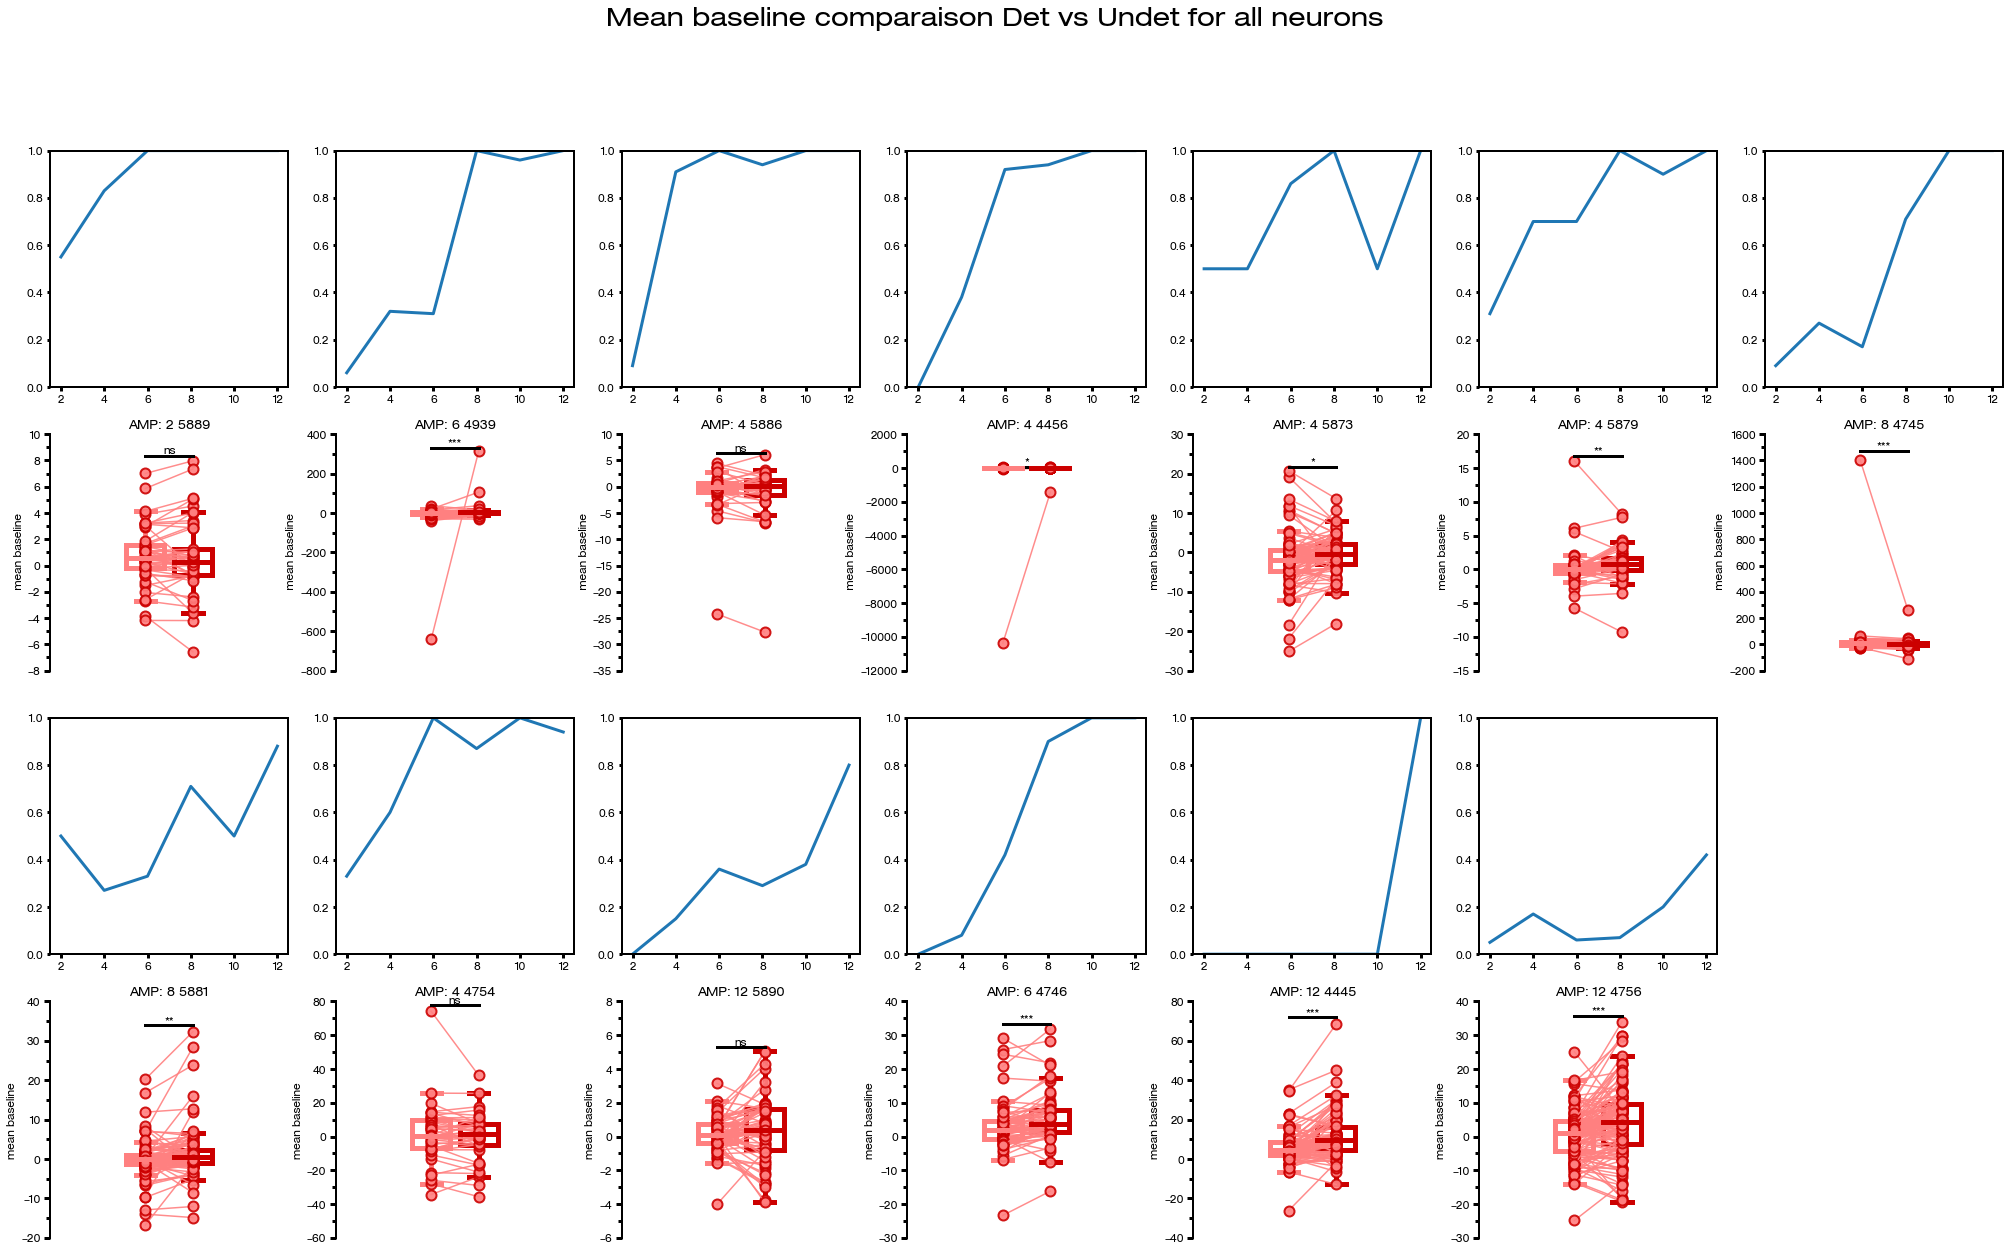

In [45]:
y, i = 0, 0
amps = [2, 6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 7, figsize=(35, 20))

for rec, amp in zip(recs,amps):
        mlr_model, model_name = mlr_m.precise_stim_model(rec)
        rec.mlr(mlr_model, model_name)
        trace = rec.df_f_exc 
        #  get all the bsl before stim of the corresponding amp stim
        stims_det = rec.stim_time[rec.detected_stim & (rec.stim_ampl == amp)]
        bsl = trace[:, np.linspace(stims_det - int(1 * rec.sf), stims_det, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_det) * int(1 * rec.sf))
        det_bsl = np.mean(bsl_, axis=1)
        stims_undet = rec.stim_time[~rec.detected_stim & (rec.stim_ampl == amp)]
        bsl = trace[:, np.linspace(stims_undet - int(1 * rec.sf), stims_undet, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_undet) * int(1 * rec.sf))
        undet_bsl = np.mean(bsl_, axis=1)
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], det_bsl, undet_bsl, " mean baseline", "AMP: " + str(amp) + " " + str(rec.filename))
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], det_bsl, undet_bsl, "mean baseline", "AMP: " + str(amp) + " " + str(rec.filename))
            y = y + 1

np.ravel(ax)[-1].set_axis_off()
ax[2, 6].set_axis_off()
fig.suptitle('Mean baseline comparaison Det vs Undet for all neurons', fontsize=26)


In this figure the baseline before the detected stimulus (1st boxplot) is compared to the baseline before the undetected stimulus for all the different recording. The amplitude of the stimulus that is chosen for each comparison is manual defined from the observation of the psychometric curve plotted above the boxplots, it should have enough detected and undetected trials to be able to do the comparison. WT mice are on the first line and KO mice are on the second line.
We can observe that the baseline is significantly higher for 4 of 6 of the KO mice and 5 out of 7 WT mice. It seems that could be an explanation of the failed detection for both genotype.

If we choose the standard deviation instead of the mean to calculate the comparison of the baseline activity: 

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.Behavioural information already incorporated in the analog.
MLR model already computed
Boxplot plotting.
 std baseline
ShapiroResult(statistic=0.8836003541946411, pvalue=0.00016699636762496084)
ShapiroResult(statistic=0.9217797517776489, pvalue=0.003065547440201044)
WilcoxonResult(

Text(0.5, 0.98, 'Std baseline comparaison Det vs Undet for all neurons')

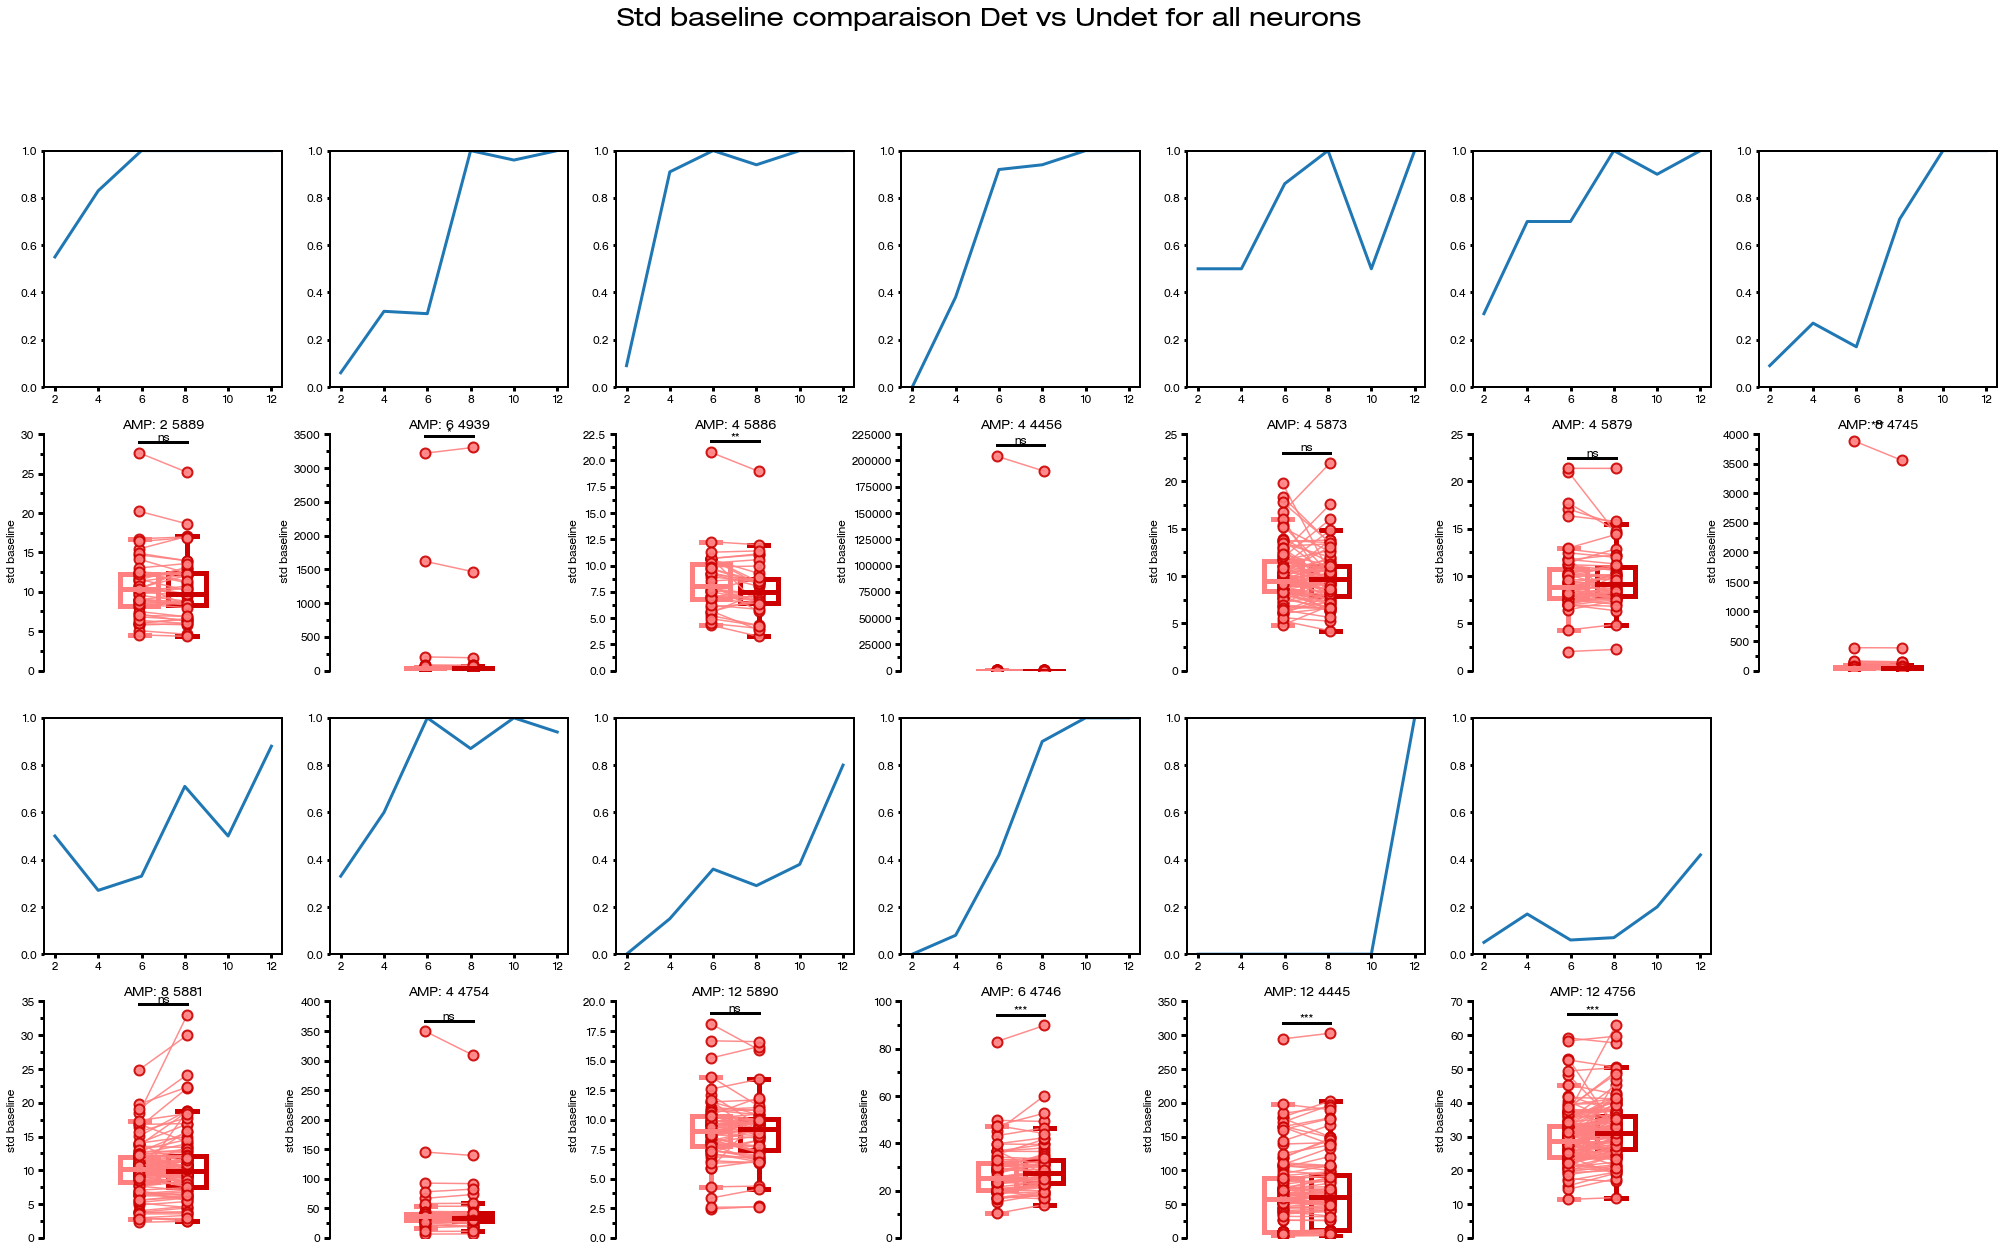

In [46]:
y, i = 0, 0
amps = [2, 6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 7, figsize=(35, 20))

for rec, amp in zip(recs,amps):
        mlr_model, model_name = mlr_m.precise_stim_model(rec)
        rec.mlr(mlr_model, model_name)
        trace = rec.df_f_exc 
        #  get all the bsl before stim of the corresponding amp stim
        stims_det = rec.stim_time[rec.detected_stim & (rec.stim_ampl == amp)]
        bsl = trace[:, np.linspace(stims_det - int(1 * rec.sf), stims_det, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_det) * int(1 * rec.sf))
        det_bsl = np.std(bsl_, axis=1)
        stims_undet = rec.stim_time[~rec.detected_stim & (rec.stim_ampl == amp)]
        bsl = trace[:, np.linspace(stims_undet - int(1 * rec.sf), stims_undet, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_undet) * int(1 * rec.sf))
        undet_bsl = np.std(bsl_, axis=1)
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], det_bsl, undet_bsl, " std baseline", "AMP: " + str(amp) + " " + str(rec.filename))
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], det_bsl, undet_bsl, "std baseline", "AMP: " + str(amp) + " " + str(rec.filename))
            y = y + 1

np.ravel(ax)[-1].set_axis_off()
ax[2, 6].set_axis_off()
fig.suptitle('Std baseline comparaison Det vs Undet for all neurons', fontsize=26)

The comparisons of the standard deviation of the baseline for KO group are still the same but for the WT group only 3 out of 7 are still significant

The next step is to compare only the neurons that were found significant with the MLR analysis, maybe the neurons silent or non-responding parasite the comparison of the baseline. We test here for all MLR neurons independently of their mlr labels

MLR model already computed
Boxplot plotting.
 mean baseline
ShapiroResult(statistic=0.971686601638794, pvalue=0.36089015007019043)
ShapiroResult(statistic=0.9534075260162354, pvalue=0.07943621277809143)
Ttest_relResult(statistic=0.8016864669723427, pvalue=0.42724696884699)
MLR model already computed
Boxplot plotting.
 mean baseline
ShapiroResult(statistic=0.9273965358734131, pvalue=0.006102691404521465)
ShapiroResult(statistic=0.8235069513320923, pvalue=5.574969691224396e-06)
WilcoxonResult(statistic=353.0, pvalue=0.025559795164699237)
MLR model already computed
Boxplot plotting.
 mean baseline
ShapiroResult(statistic=0.9393168687820435, pvalue=0.09622197598218918)
ShapiroResult(statistic=0.9238410592079163, pvalue=0.038189951330423355)
WilcoxonResult(statistic=180.0, pvalue=0.4174403049093858)
MLR model already computed
Boxplot plotting.
 mean baseline
ShapiroResult(statistic=0.07349348068237305, pvalue=1.7989974521286985e-23)
ShapiroResult(statistic=0.11254900693893433, pvalue=4.6913

Text(0.5, 0.98, 'Mean baseline comparaison Det vs Undet for MLR significant neurons')

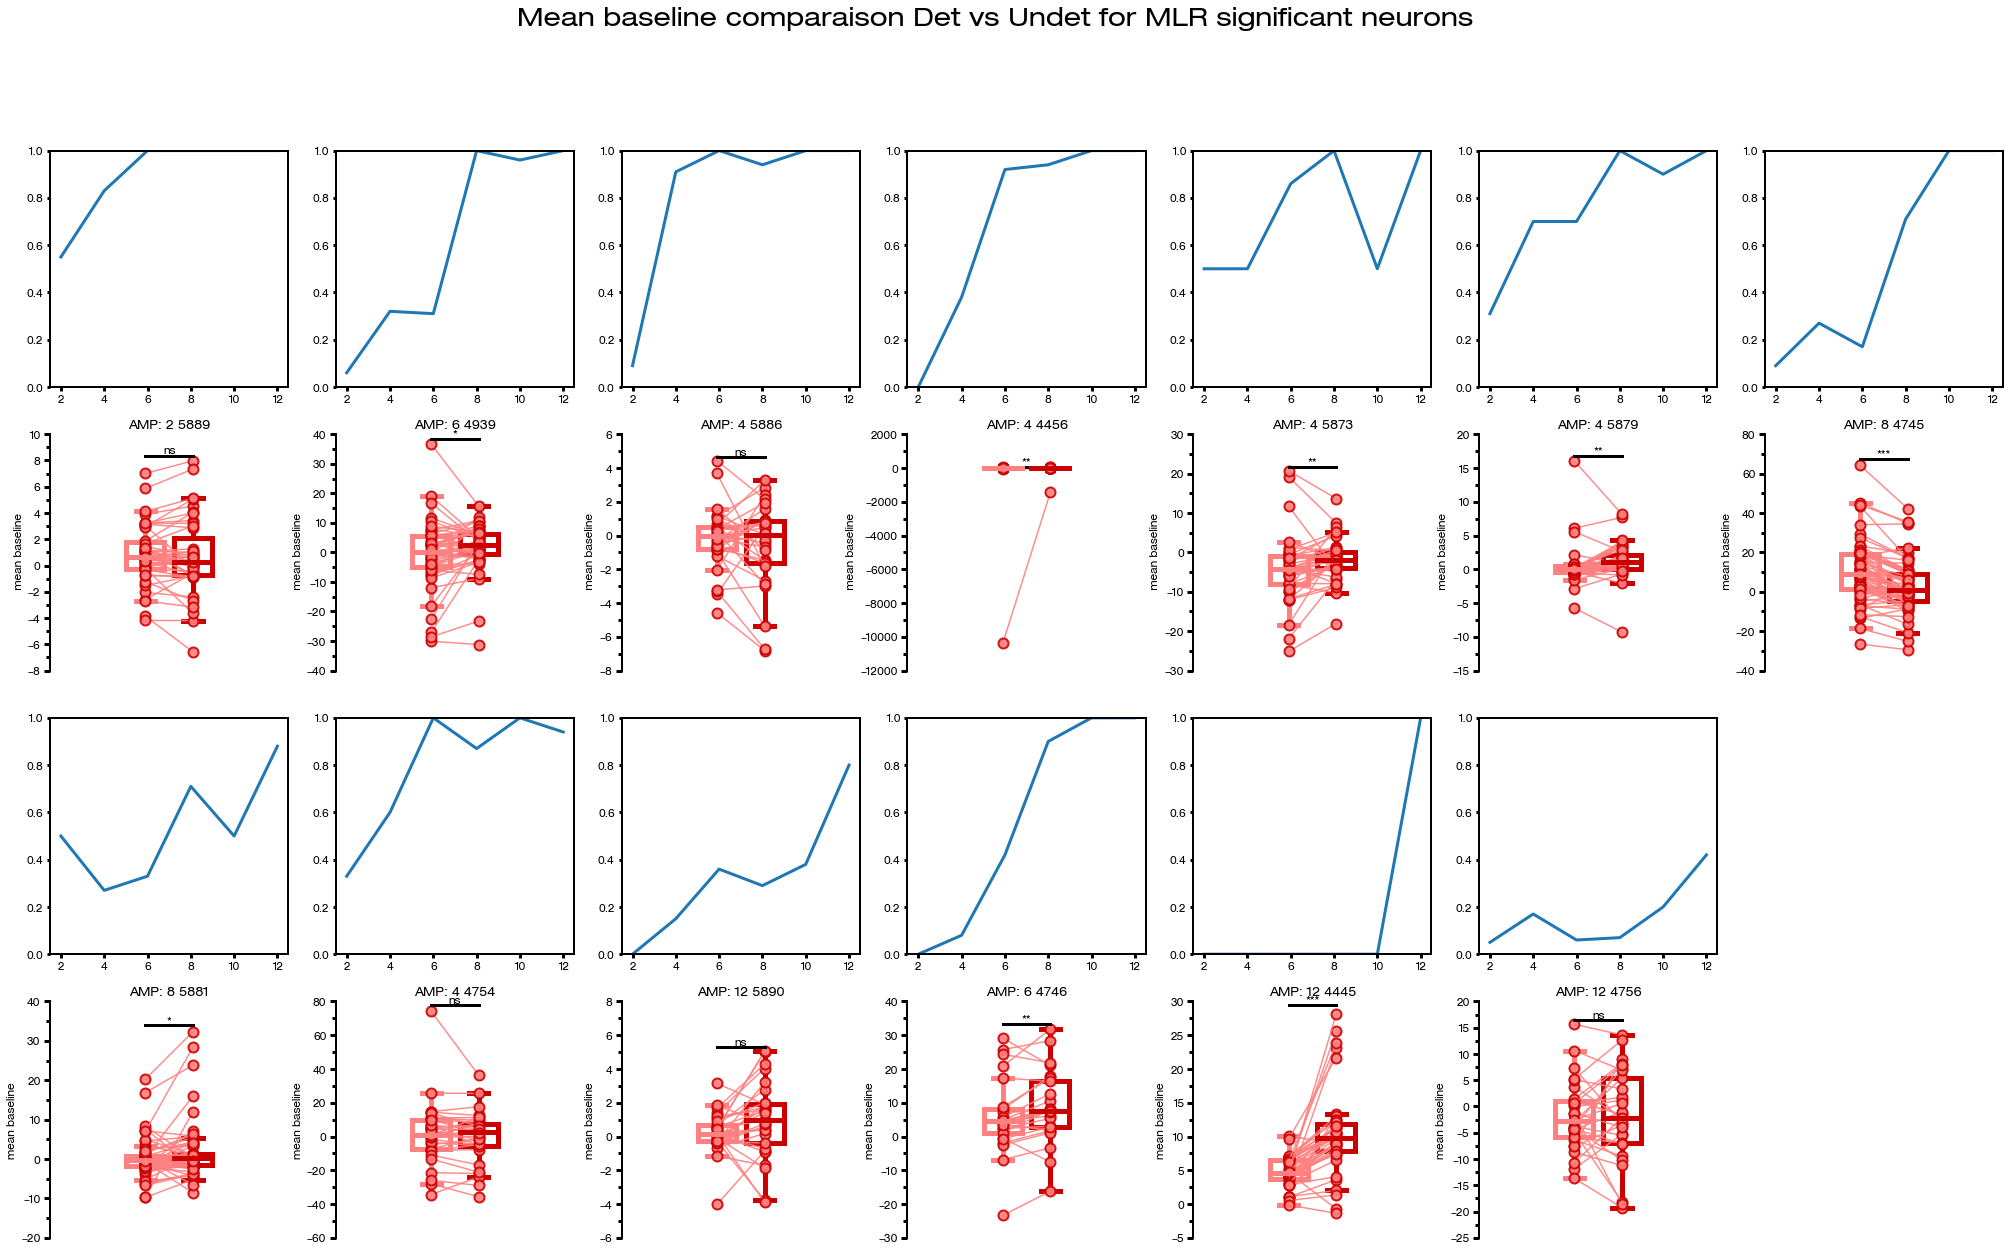

In [47]:
y, i = 0, 0
amps = [2, 6, 4, 4, 4, 8, 4, 4, 12, 8, 6, 12, 12]  # manual selection of the threshold amp for each animal from psychometric curves
fig, ax = plt.subplots(4, 7, figsize=(35, 20))

for rec, amp in zip(recs,amps):
        mlr_model, model_name = mlr_m.precise_stim_model(rec)
        rec.mlr(mlr_model, model_name)
        trace = rec.df_f_exc[rec.mlr_labels_exc["indices_r2"]] # we select only neurons with a significant r2
        #  get all the bsl before stim of the corresponding amp stim
        stims_det = rec.stim_time[rec.detected_stim & (rec.stim_ampl == amp)]
        bsl = trace[:, np.linspace(stims_det - int(1 * rec.sf), stims_det, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_det) * int(1 * rec.sf))
        det_bsl = np.mean(bsl_, axis=1)
        stims_undet = rec.stim_time[~rec.detected_stim & (rec.stim_ampl == amp)]
        bsl = trace[:, np.linspace(stims_undet - int(1 * rec.sf), stims_undet, int(1 * rec.sf), dtype=int)]
        bsl_ = bsl.reshape(len(trace), len(stims_undet) * int(1 * rec.sf))
        undet_bsl = np.mean(bsl_, axis=1)
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], det_bsl, undet_bsl, " mean baseline", "AMP: " + str(amp) + " " + str(rec.filename))
            i = i + 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], det_bsl, undet_bsl, "mean baseline", "AMP: " + str(amp) + " " + str(rec.filename))
            y = y + 1

np.ravel(ax)[-1].set_axis_off()
ax[2, 6].set_axis_off()
fig.suptitle('Mean baseline comparaison Det vs Undet for MLR significant neurons', fontsize=26)

The global trend seems to be the same in KO mice but lot less significant animals. The result is opposite of what we hypothesised before. It seems even that in WT group the dynamic is opposite, the firing neurons have lower baseline in non detected stimulus. Similar analysis should be made with a discrimination of the  clusters of neurons 

